# Introduction

This my first pass at trying to check if my star parameters worked.

I used the version of star and the annotation files included in the 10x cellranger-arc archive as the closest check I could manage.

In [1]:
import scipy
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot
import sys

In [2]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [3]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [4]:
def scanpy_load_solo272_default_mtx(analysis_dir, quantification="Gene"):
    #assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"

    analysis_dir = Path(analysis_dir)
    matrix_name = {
        "Gene": "matrix.mtx",
        "GeneFull": "matrixGeneFull.mtx",
        "SJ": "matrixSJ",
    }[quantification]
    feature_name = "genes.tsv"
    
    solo_dir = analysis_dir / "Solo.out"
    solo = scanpy.read_mtx(solo_dir / matrix_name).T
    solo_vars = pandas.read_csv(
        solo_dir / feature_name, header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



In [5]:
tenx_root = Path('ENCSR724KET_cr-arc')
tenx_raw_path = tenx_root / 'outs' / 'raw_feature_bc_matrix'
tenx_filtered_path = tenx_root / 'outs' / 'filtered_feature_bc_matrix'

In [6]:
tenx_filtered = scanpy.read_10x_mtx(tenx_filtered_path, var_names='gene_ids')
tenx_filtered.obs_names = [x[:-2] for x in tenx_filtered.obs_names]

In [11]:
solo272_default_root = Path("cr-arc-star_defaults")
solo272_default_gene = scanpy_load_solo272_default_mtx(solo272_default_root, "Gene")
solo272_default_genefull = scanpy_load_solo272_default_mtx(solo272_default_root, "GeneFull")

In [12]:
print("tenx filtered", tenx_filtered.shape, tenx_filtered.X.sum())
print("solo gene", solo272_default_gene.shape, solo272_default_gene.X.sum())
print("solo genefull", solo272_default_genefull.shape, solo272_default_genefull.X.sum())

tenx filtered (13650, 36601) 80119070.0
solo gene (736320, 36601) 0.0
solo genefull (736320, 36601) 120679656.0


solo gene is empty? That's really weird

In [13]:
solo272_filtered_genefull = solo272_genefull[tenx_filtered.obs_names,:]
solo272_filtered_genefull.shape, solo272_filtered_genefull.X.sum()

((13650, 36601), 107491280.0)

In [14]:
solo272_filtered_genefull.X.sum(axis=1).shape

(13650, 1)

In [15]:
filtered_cors = compute_spearman_anndata(tenx_filtered, solo272_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [16]:
tenx_filtered

AnnData object with n_obs × n_vars = 13650 × 36601
    var: 'gene_symbols', 'feature_types'

In [17]:
tenx_filtered.obs_names

Index(['AAACAGCCACGTGCTG', 'AAACAGCCACTTAGGC', 'AAACAGCCAGGGAGCT',
       'AAACAGCCATGTTTGG', 'AAACATGCAAACGGGC', 'AAACATGCAAGGGTTG',
       'AAACATGCAATTGAGA', 'AAACATGCACCCACAG', 'AAACATGCAGGAAGCC',
       'AAACATGCAGGGAGGA',
       ...
       'TTTGTGTTCTAAGGTC', 'TTTGTGTTCTAAGTCA', 'TTTGTTGGTAATCACG',
       'TTTGTTGGTAGGTTGC', 'TTTGTTGGTCCTAAGA', 'TTTGTTGGTGAGCAAG',
       'TTTGTTGGTGCTCACC', 'TTTGTTGGTGCTTACT', 'TTTGTTGGTGCTTAGA',
       'TTTGTTGGTTACATCC'],
      dtype='object', length=13650)

In [18]:
tenx_filtered_sum = pandas.Series(numpy.asarray(tenx_filtered.X.sum(axis=1)).T[0])


In [20]:
tenx_filtered_maxidx = tenx_filtered_sum.idxmax()
tenx_max_cell = tenx_filtered.obs_names[tenx_filtered_maxidx]
tf = tenx_filtered[tenx_max_cell].to_df().T
tf.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,3.866807
std,72.393562
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13634.000000


In [21]:
sfgf = solo272_filtered_genefull[tenx_max_cell].to_df().T
sfgf.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,5.568810
std,77.459137
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,14299.000000


In [22]:
assert numpy.all(tf.index == sfgf.index), "feature lists are not in same order "

In [23]:
rad = (numpy.abs(sfgf - tf) / numpy.maximum(sfgf, tf))

<AxesSubplot:ylabel='Frequency'>

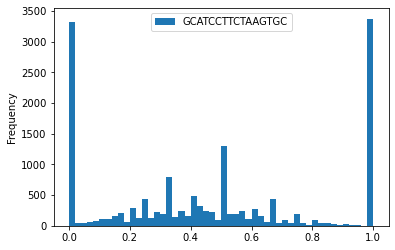

In [25]:
rad.plot.hist(bins=50)

In [26]:
combined = pandas.merge(sfgf, tf, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo

<ipython-input-27-7e7baa53eaaf>:4: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)


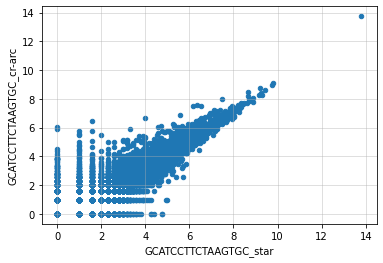

In [27]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(combined).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(0,1e5)
#ax.set_ylim(0,1e5)
ax.grid(alpha=.5)

In [29]:
genefull_cors = compute_spearman_anndata(tenx_filtered, solo272_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Compare per cell spearman correlation

There is a warning message from the spearman function complaining that the input matrix has an issue, so this histogram may be incorrect.

<AxesSubplot:ylabel='Frequency'>

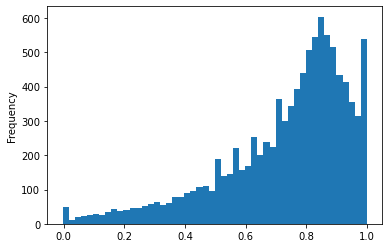

In [30]:
genefull_cors.plot.hist(bins=50)